<a href="https://colab.research.google.com/github/n00bby/LinkedLists/blob/main/House_Prices_Advanced_Regression_Techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
# !pip install lazypredict

In [64]:
# Import helpful libraries
import pandas as pd
import numpy as np
import seaborn as sns
from lightgbm import LGBMRegressor
# from sklearn import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from lazypredict.Supervised import LazyRegressor

In [65]:
# Load the data, and separate the target
home_data = pd.read_csv('train.csv', index_col='Id')
y = home_data.SalePrice
home_data.drop(['SalePrice'], axis=1, inplace=True)
# read test data file using pandas
test_data = pd.read_csv('test.csv', index_col='Id')

In [66]:
test_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,CBlock,TA,TA,No,Rec,468.00,LwQ,144.00,270.00,882.00,GasA,TA,Y,SBrkr,896,0,0,896,0.00,0.00,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.00,Unf,1.00,730.00,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.00,TA,TA,CBlock,TA,TA,No,ALQ,923.00,Unf,0.00,406.00,1329.00,GasA,TA,Y,SBrkr,1329,0,0,1329,0.00,0.00,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.00,Unf,1.00,312.00,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.00,TA,TA,PConc,Gd,TA,No,GLQ,791.00,Unf,0.00,137.00,928.00,GasA,Gd,Y,SBrkr,928,701,0,1629,0.00,0.00,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.00,Fin,2.00,482.00,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.00,TA,TA,PConc,TA,TA,No,GLQ,602.00,Unf,0.00,324.00,926.00,GasA,Ex,Y,SBrkr,926,678,0,1604,0.00,0.00,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.00,Fin,2.00,470.00,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.00,Gd,TA,PConc,Gd,TA,No,ALQ,263.00,Unf,0.00,1017.00,1280.00,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.00,0.00,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.00,RFn,2.00,506.00,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [67]:
def cleaning(home_data, filln=True):
  """Cleaned train and test data for better prediction"""
  if filln:
    home_data.fillna(0, inplace=True)
  for i in home_data.columns:
    if home_data[i].dtype == 'object':
      for num, condition in enumerate(list(home_data[i].unique())):
        home_data[i] = np.where(home_data[i] == condition, num, home_data[i])
  return home_data.astype('float')

In [68]:
def pro_cleaning(X_train=home_data, X_valid=test_data):
# X_train=home_data
# X_valid=test_data
  # imp_X_train = X_train.select_dtypes(exclude=['object'])
  # imp_X_valid = X_valid.select_dtypes(exclude=['object'])

  # imputer = SimpleImputer()
  # imputed_X_train = pd.DataFrame(imputer.fit_transform(imp_X_train))
  # imputed_X_test = pd.DataFrame(imputer.transform(imp_X_valid))
  # imputed_X_train.columns = imp_X_train.columns
  # imputed_X_test.columns = imp_X_valid.columns

  # define columns with dtype - 'object'
  object_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]

  # Columns that will be one-hot encoded
  low_cardinality_cols = [col for col in object_cols if X_train[col].nunique() < 10]

  # Columns that will be dropped from the dataset
  high_cardinality_cols = list(set(object_cols)-set(low_cardinality_cols))

  high_card_X_train = cleaning(X_train).drop(low_cardinality_cols, axis=1)
  high_card_X_valid = cleaning(X_valid).drop(low_cardinality_cols, axis=1)

  OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

  OH_X_train = X_train[object_cols].fillna('0')
  OH_X_valid = X_valid[object_cols].fillna('0')

  OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(OH_X_train[low_cardinality_cols]))
  OH_cols_valid = pd.DataFrame(OH_encoder.transform(OH_X_valid[low_cardinality_cols]))

  # One-hot encoding removed index; put it back
  OH_cols_train.index = X_train.index
  OH_cols_valid.index = X_valid.index

  reduced_X_train = X_train.drop(low_cardinality_cols, axis=1)
  reduced_X_valid = X_valid.drop(low_cardinality_cols, axis=1)

  # Add one-hot encoded columns to numerical features
  OH_X_train = pd.concat([OH_cols_train, high_card_X_train, reduced_X_train], axis=1)
  OH_X_valid = pd.concat([OH_cols_valid, high_card_X_valid, reduced_X_valid], axis=1)
  #  drop the column's duplicates
  OH_X_train = OH_X_train.loc[:,~OH_X_train.columns.duplicated()]
  OH_X_valid = OH_X_valid.loc[:,~OH_X_valid.columns.duplicated()]

  columns = [column for column in OH_X_train.columns if isinstance(column, int) == False]

  return OH_X_train[columns].fillna(0), OH_X_valid[columns].fillna(0)

In [69]:
# Create X (After completing the exercise, you can return to modify this line!)
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
           'OverallCond', 'GarageCars', 'MSSubClass', 'OverallQual', 'ExterCond', 'BsmtFinSF1', 
            'Fireplaces', 'GarageCond', 'Neighborhood', 'BsmtFinType1', 'TotalBsmtSF', 'GrLivArea', 'KitchenQual',
            'RoofMatl']

# cleaning data and changing string values to int in the choosen columns
# X = cleaning(home_data)[features]
# X_test = cleaning(test_data)[features]

In [70]:
# The list of columns is stored in a variable called features
X, X_test = cleaning(home_data, True), cleaning(test_data, True)

In [71]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60.00,0.00,65.00,8450.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,5.00,2003.00,2003.00,0.00,0.00,0.00,0.00,4.00,196.00,0.00,0.00,0.00,3.00,2.00,4.00,5.00,706.00,2.00,0.00,150.00,856.00,0.00,0.00,0.00,5.00,856.00,854.00,0.00,1710.00,1.00,0.00,2.00,1.00,3.00,1.00,0.00,8.00,0.00,0.00,0.00,4.00,2003.00,3.00,2.00,548.00,3.00,2.00,0.00,0.00,61.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2008.00,0.00,0.00
2,20.00,0.00,80.00,9600.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00,1.00,6.00,8.00,1976.00,1976.00,0.00,0.00,1.00,1.00,1.00,0.00,1.00,0.00,1.00,3.00,2.00,1.00,1.00,978.00,2.00,0.00,284.00,1262.00,0.00,0.00,0.00,5.00,1262.00,0.00,0.00,1262.00,0.00,1.00,2.00,0.00,3.00,1.00,1.00,6.00,0.00,1.00,1.00,4.00,1976.00,3.00,2.00,460.00,3.00,2.00,0.00,298.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,0.00,0.00
3,60.00,0.00,68.00,11250.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,5.00,2001.00,2002.00,0.00,0.00,0.00,0.00,4.00,162.00,0.00,0.00,0.00,3.00,2.00,2.00,5.00,486.00,2.00,0.00,434.00,920.00,0.00,0.00,0.00,5.00,920.00,866.00,0.00,1786.00,1.00,0.00,2.00,1.00,3.00,1.00,0.00,6.00,0.00,1.00,1.00,4.00,2001.00,3.00,2.00,608.00,3.00,2.00,0.00,0.00,42.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,2008.00,0.00,0.00
4,70.00,0.00,60.00,9550.00,0.00,0.00,1.00,0.00,0.00,2.00,0.00,2.00,0.00,0.00,0.00,0.00,7.00,5.00,1915.00,1970.00,0.00,0.00,2.00,2.00,1.00,0.00,1.00,0.00,2.00,1.00,1.00,4.00,1.00,216.00,2.00,0.00,540.00,756.00,0.00,1.00,0.00,5.00,961.00,756.00,0.00,1717.00,1.00,0.00,1.00,0.00,3.00,1.00,0.00,7.00,0.00,1.00,2.00,1.00,1998.00,1.00,3.00,642.00,3.00,2.00,0.00,0.00,35.00,272.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,2006.00,0.00,1.00
5,60.00,0.00,84.00,14260.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,3.00,0.00,0.00,0.00,0.00,8.00,5.00,2000.00,2000.00,0.00,0.00,0.00,0.00,4.00,350.00,0.00,0.00,0.00,3.00,2.00,3.00,5.00,655.00,2.00,0.00,490.00,1145.00,0.00,0.00,0.00,5.00,1145.00,1053.00,0.00,2198.00,1.00,0.00,2.00,1.00,4.00,1.00,0.00,9.00,0.00,1.00,1.00,4.00,2000.00,3.00,3.00,836.00,3.00,2.00,0.00,192.00,84.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12.00,2008.00,0.00,0.00


In [72]:
X_test.shape

(1459, 79)

In [73]:
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [74]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=mean_absolute_error)
models, predictions = reg.fit(train_X, val_X, train_y, val_y)
models

100%|██████████| 42/42 [00:12<00:00,  3.27it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mean_absolute_error
Model,,,,,
GradientBoostingRegressor,0.91,0.93,21278.60,0.68,14394.72
RandomForestRegressor,0.87,0.89,26580.39,1.87,16396.09
TransformedTargetRegressor,0.86,0.89,27231.06,0.03,19567.37
LinearRegression,0.86,0.89,27231.06,0.05,19567.37
Lasso,0.86,0.89,27234.06,0.15,19564.26
LassoLars,0.86,0.89,27273.02,0.07,19532.84
HistGradientBoostingRegressor,0.86,0.89,27280.47,1.47,15455.67
Ridge,0.86,0.89,27295.33,0.03,19578.82
LGBMRegressor,0.86,0.89,27539.58,0.33,15227.17


In [75]:
one, two , three = GradientBoostingRegressor(random_state=1), LGBMRegressor(random_state=1), HistGradientBoostingRegressor(random_state=1)
models = [one, two, three]

def prediction(X=X, y=y, models=models, mae_=False):
  """fit, validate, and predict score from models in the 'models' list
    returns a list mean_absolute_errors for each model if mae=True, and
    a list with predictions of given X and y sets if mae=False or not given.
  """
  global X_test, val_y, val_X
  fits = [model.fit(X, y) for model in models]
  predictions = [model.predict(val_X) for model in models]
  if mae_:
    mae = [mean_absolute_error(prediction, val_y) for prediction in predictions]
    return mae
  return fits
  
mae = prediction(train_X, train_y, models, True)

for i in range(len(mae)):
  print(f"Validation MAE for Model {i}: {mae[i]:,.0f}")

Validation MAE for Model 0: 14,510
Validation MAE for Model 1: 15,365
Validation MAE for Model 2: 15,456


In [76]:
# make predictions which we will submit.
preds = [model.predict(X_test) for model in prediction(X, y)]

In [77]:
# Run the code to save predictions in the format used for competition scoring
output = [pd.DataFrame({'Id': test_data.index, 'SalePrice': data}) for data in preds] 

In [78]:
# # save the submission
# for submission in range(len(output)):
#   output[submission].to_csv(f'submission {submission}.csv', index=False)

In [79]:
df = output[0].merge(output[1], on='Id').merge(output[2], on='Id')
# df.set_index('Id', inplace=True)
df.set_axis(['Id', 'GBR', 'LGBMR', 'HGBR'], axis='columns', inplace=True)
df.head()

,Id,GBR,LGBMR,HGBR
0,1461,117055.53,122415.16,126078.28
1,1462,142159.16,140058.70,149462.46
2,1463,162685.83,165098.30,175565.79
3,1464,171157.27,174346.02,186176.39
4,1465,173948.33,181218.83,194386.08


In [86]:
df['mean'] = (df.LGBMR + df.HGBR) / 2
df['Std'] = df[[ 'LGBMR', 'HGBR']].std(axis=1)
df['median'] = df[['LGBMR', 'HGBR']].median(axis=1)
df['SalePrice'] = df[['mean', 'median']].mean(axis=1)
final_df = df.drop(['GBR', 'LGBMR', 'HGBR', 'mean', 'median', 'Std'], axis=1)
df

,Id,GBR,LGBMR,HGBR,mean,Std,median,SalePrice
0,1461,117055.53,122415.16,126078.28,124246.72,2590.21,124246.72,124246.72
1,1462,142159.16,140058.70,149462.46,144760.58,6649.46,144760.58,144760.58
2,1463,162685.83,165098.30,175565.79,170332.05,7401.63,170332.05,170332.05
3,1464,171157.27,174346.02,186176.39,180261.21,8365.33,180261.21,180261.21
4,1465,173948.33,181218.83,194386.08,187802.46,9310.65,187802.46,187802.46
...,...,...,...,...,...,...,...,...
1454,2915,63172.57,80814.02,83904.35,82359.19,2185.19,82359.19,82359.19
1455,2916,67978.91,83098.62,81373.36,82235.99,1219.95,82235.99,82235.99
1456,2917,164220.25,171241.33,163042.07,167141.70,5797.76,167141.70,167141.70
1457,2918,103337.58,105001.66,111783.93,108392.79,4795.79,108392.79,108392.79


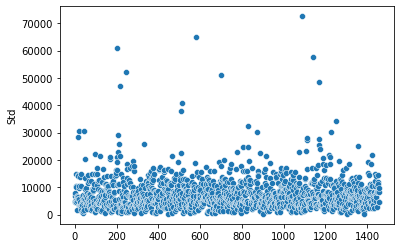

In [81]:
sns.scatterplot(df.index, df.Std)

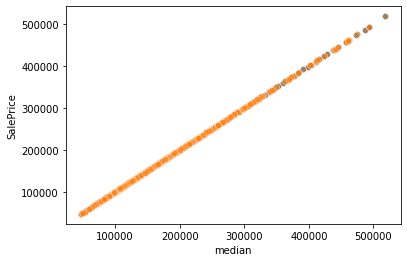

In [87]:
sns.scatterplot(x='median', y='SalePrice', data=df, alpha=0.9)
sns.scatterplot(x='mean', y='SalePrice', data=df, alpha=0.5)

In [88]:
final_df.to_csv('submission the Ensemble without GBR.csv', index=False)